In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100

import japanize_matplotlib
import seaborn as sns
import pandas_profiling as pdp
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
import collections
import re
import feather
import codecs

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

In [2]:
train=pd.read_csv('../input/train.csv')
test=pd.read_csv('../input/test.csv')
df_all=pd.concat([train,test],axis=0,sort=False).reset_index(drop=True)
df_all.columns=['id','rent','address','access','floor_info','old','direction','square','floor','bath','kitchen','broadcast','facility','parking','neighbors','structure','period']

train_feat4=pd.read_feather('feature4/data/train_feat4_all.ftr')
test_feat4=pd.read_feather('feature4/data/test_feat4_all.ftr').drop('index',axis=1)
df_all_feat4=pd.concat([train_feat4,test_feat4],axis=0,sort=False).reset_index(drop=True)
train_index=len(train_feat4)
test_index=len(test_feat4)

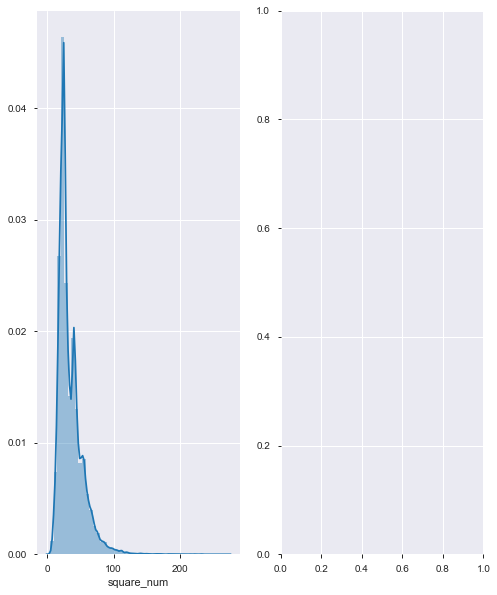

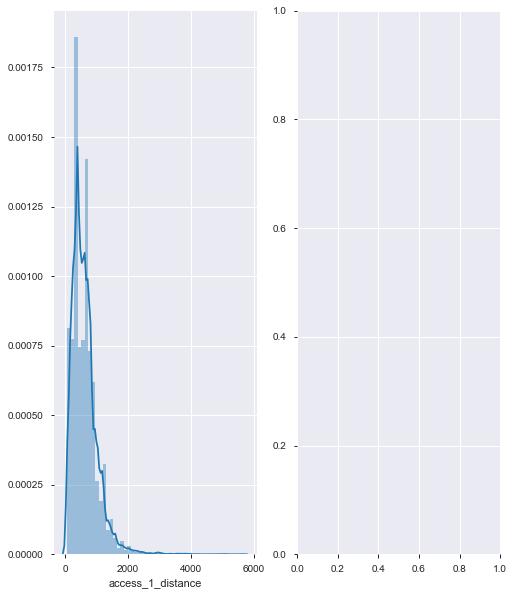

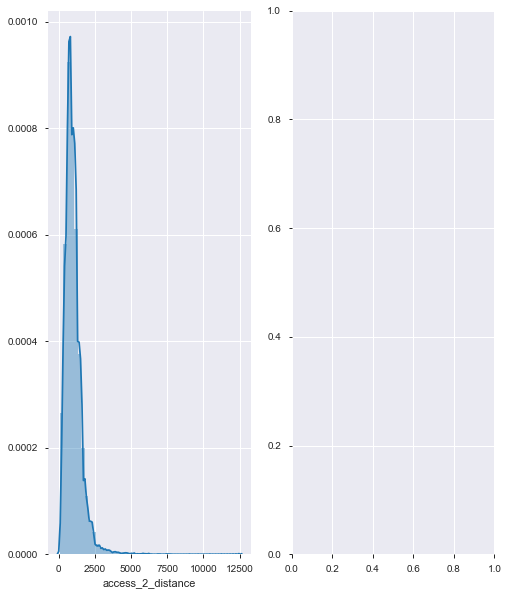

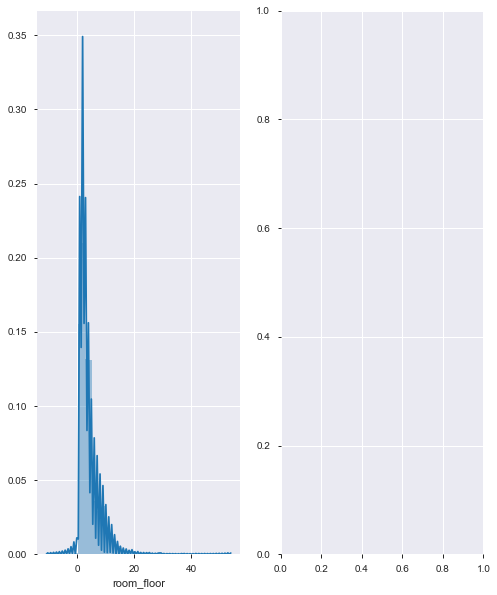

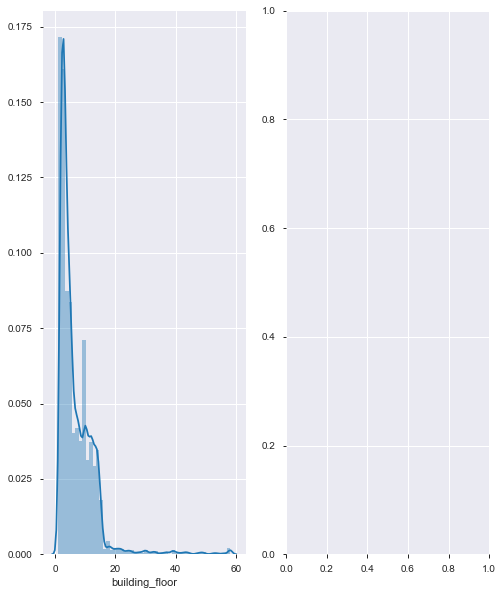

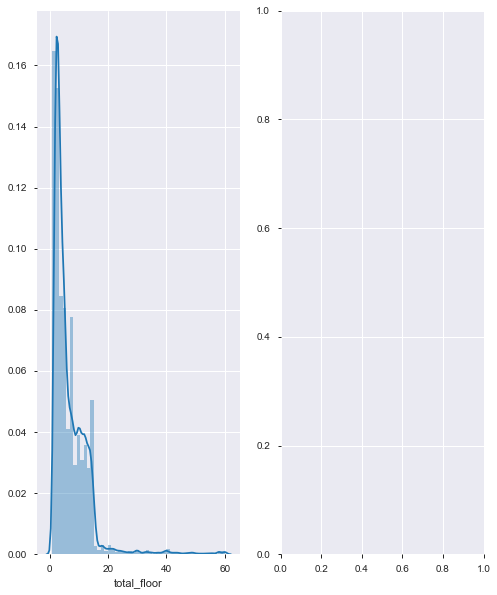

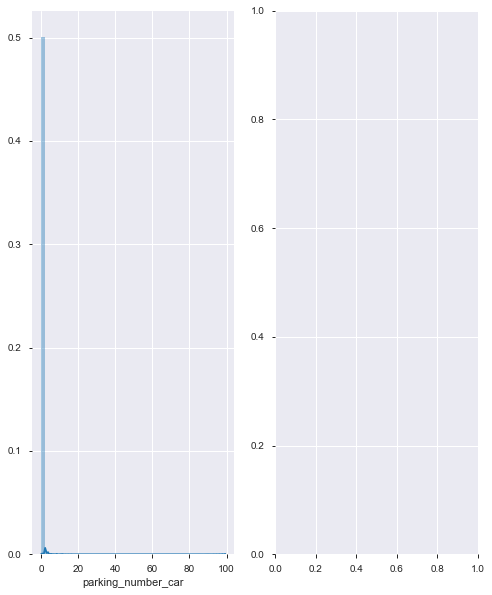

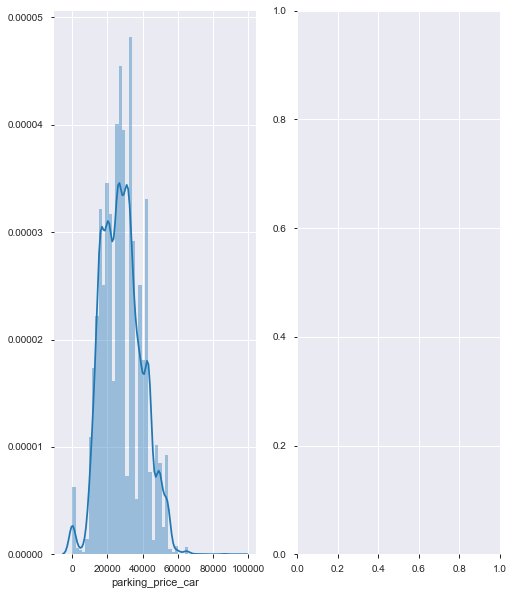

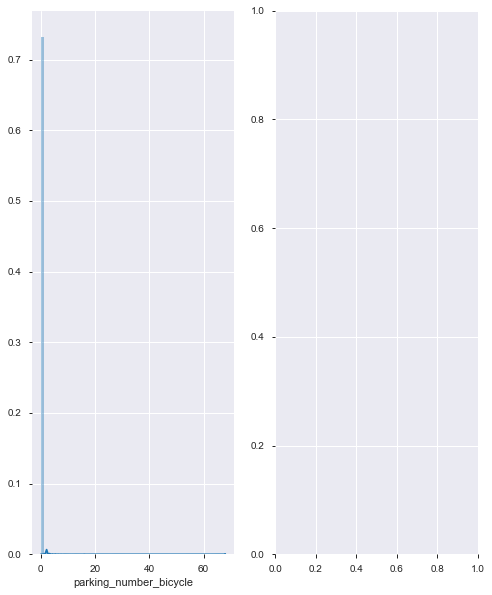

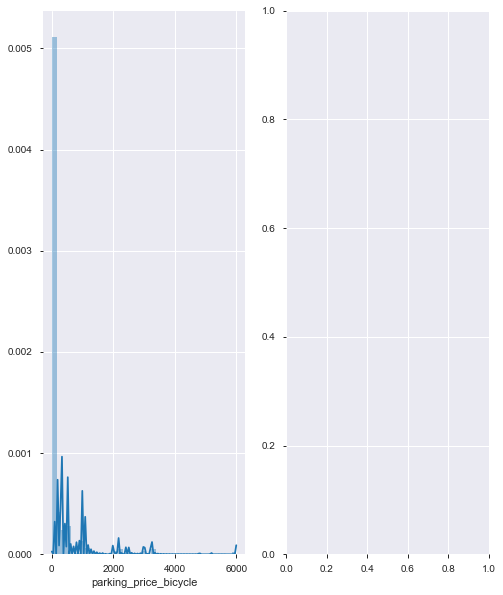

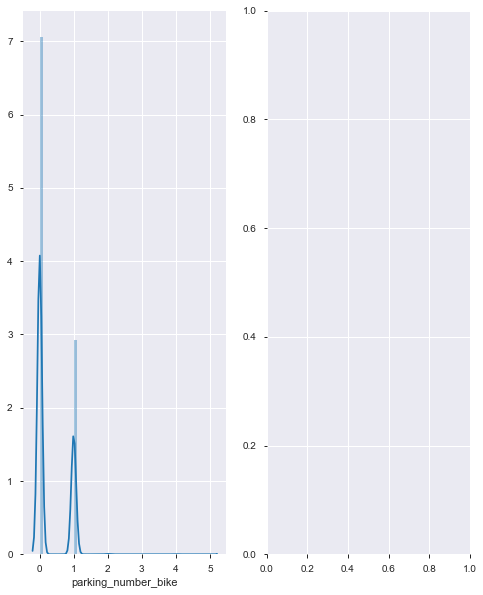

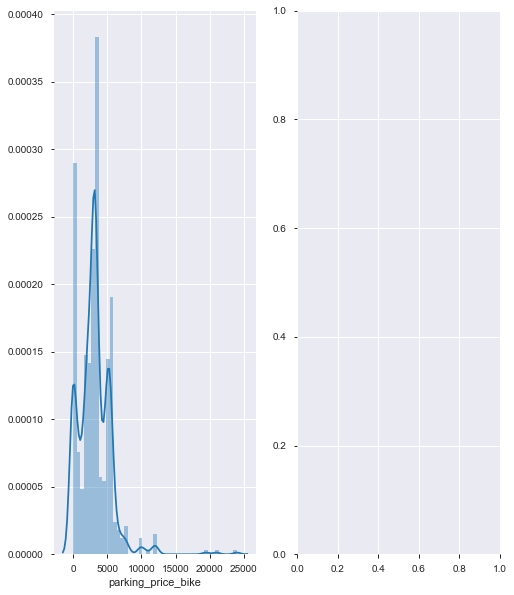

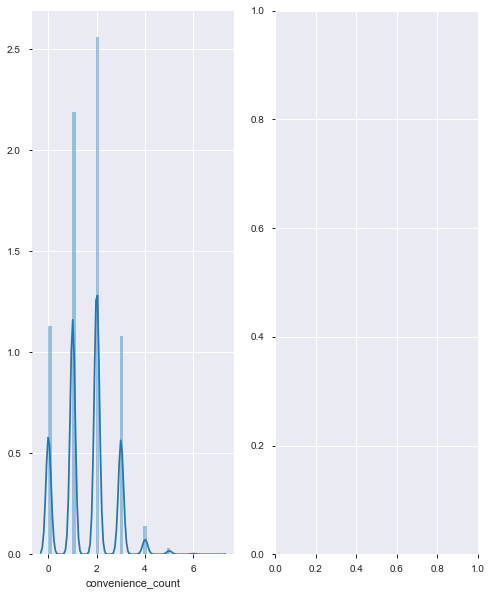

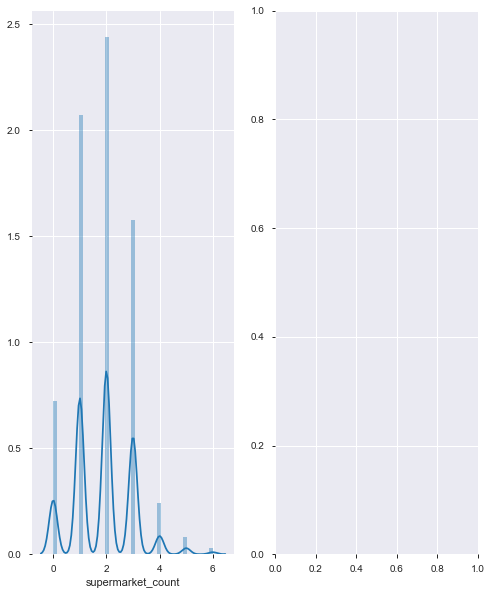

In [ ]:
continuous_cols=['square_num','access_1_distance','access_2_distance','room_floor','building_floor','total_floor','parking_number_car',
                        'parking_price_car', 'parking_number_bicycle', 'parking_price_bicycle',
   'parking_number_bike', 'parking_price_bike', 'convenience_count',
       'supermarket_count', 'neighbor_count', 'デパート', '幼稚園・保育園', '図書館',
       'ドラッグストア', '郵便局', '大学', '公園', 'スーパー', '銀行', 'コインパーキング', 'レンタルビデオ',
       '飲食店', '小学校', 'コンビニ', '病院', '総合病院', '月極駐車場', 'クリーニング', '学校',
       'resistance_period', 'old_num', 'available_period','period_num', 'future_available']

for col in continuous_cols:
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,10))
    sns.distplot(train_feat4[train_feat4[col]!=-999][col],ax=ax[0])
  #  sns.distplot(np.log(train_feat4[train_feat4[col]!=-999][col]),ax=ax[1])
    plt.show()

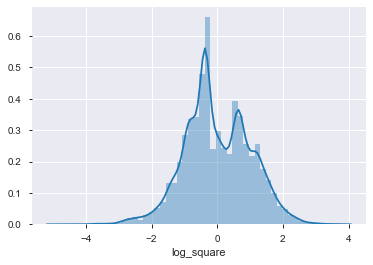

In [11]:
from sklearn.preprocessing import PowerTransformer

pt=PowerTransformer(method='yeo-johnson')
pt.fit(train_feat4['square_num'].values.reshape(-1, 1))

train_feat4['log_square']=pt.transform(train_feat4['square_num'].values.reshape(-1, 1))
sns.distplot(train_feat4['log_square'])